# 각각 Spatial, Pixel 증강 + 기본 CNN(epoch=40)

# 데이터 불러오기 및 라벨링

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-08-30 17:22:45.250902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 17:22:45.322178: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4 Physical GPUs, 4 Logical GPUs


2024-08-30 17:22:48.212523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 17:22:49.869302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14825 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-08-30 17:22:49.870401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14825 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-08-30 17:22:49.871359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

### step1: 질병이 있음/없음만 구분

In [2]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [3]:
image_paths[0:5]

['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_10.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_100.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_101.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_102.tiff']

In [4]:
print(image_labels[0:50])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 391)

Aom_cnt = 119  
Chornic_cnt = 62  
Earwax_cnt = 140  
Normal_cnt = 534  
OtitExterna_cnt = 41  
tympanoskleros_cnt = 28  

# Split the Dataset 6 : 2 : 2 

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [7]:
# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 592
Validation set: 148
Test set: 185


In [8]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 342
Abnormal in Train set: 250


In [9]:
print("image_paths shape:",image_paths.shape)
print("image_labels shape:",image_labels.shape)

image_paths shape: (925,)
image_labels shape: (925,)


# train dataset을 Augmentation

#### A. 여러 종류의 증강함수를 만들기   

### 1. Spatial-Level Transforms

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

In [11]:
def flip_H(image):
    return tf.image.flip_left_right(image)

def flip_V(image):
    return tf.image.flip_up_down(image)

def rotate(image):
    # k = random.randint(1, 3)
    # rotated = tf.image.rot90(image, k)
    angle = random.uniform(0, 360)
    rotated = tf.image.rot90(image, k=int(angle // 90))
    return rotated

def crop(image):
    cropped = tf.image.central_crop(image, central_fraction=0.5)
    return cropped

In [12]:
def load_and_preprocess_image(path, target_size=(250, 250)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image

In [13]:
# 이미지 경로로부터 이미지를 로드
ex_path = x_train_all[50]  # 예시 이미지 경로
image = load_and_preprocess_image(ex_path)

Spatial_aug = {
    'flip_H': flip_H(image),
    'flip_V': flip_V(image),
    'rotate': rotate(image)
    #'crop': crop(image)
}

# 이미지를 시각화하기 위한 함수
def visualize_Spatial(image, Spatial_aug):
    fig, axes = plt.subplots(1, len(Spatial_aug) + 1, figsize=(10, 8))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(Spatial_aug.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

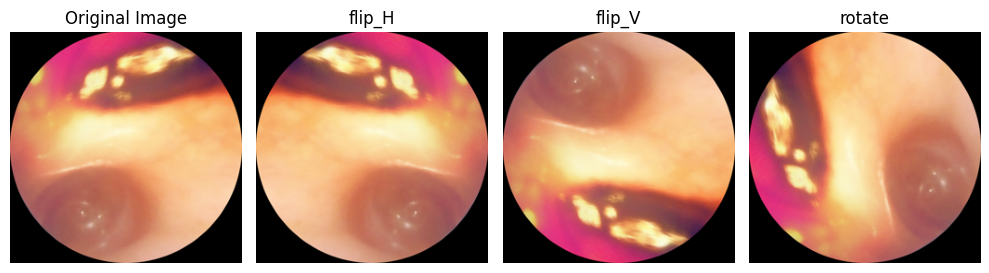

In [14]:
visualize_Spatial(image, Spatial_aug)

### 2.Pixel-Level Transforms

In [15]:
def CLAHE(image):
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)) #2.0
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image
    
def Hue(image):
    hue_img = tf.image.adjust_hue(image, delta=0.1)
    hue_img = tf.image.adjust_saturation(hue_img, saturation_factor=1)
    return hue_img
    # delta = random.uniform(-0.5, 0.5)
    # return tf.image.adjust_hue(image, delta=delta)

def RandomContrast(image):
    # contrast_image = tf.image.random_contrast(image, lower=1.0, upper=3.0)
    # contrast_image = tf.clip_by_value(contrast_image, 0.0, 1.0)  # 클리핑
    # return contrast_image
    lower, upper = 0.5, 2.0  # 대비 범위 변경
    return tf.image.random_contrast(image, lower=lower, upper=upper)

def RandomGamma(image):
    # gamma_img = tf.image.adjust_gamma(image, gamma=0.5)
    # return gamma_img
    gamma = random.uniform(0.2, 2.0)
    return tf.image.adjust_gamma(image, gamma=gamma)

def RandomBrightness(image):
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    image = image.numpy()
    # blur_img = cv2.blur(image, (5, 5))
    # return blur_img
    kernel_size = random.choice([(5, 5), (7, 7), (9, 9), (13,13)])
    return cv2.blur(image, kernel_size)

def gray(image):
    # ToGray
    togray_img = tf.image.rgb_to_grayscale(image)
    return togray_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


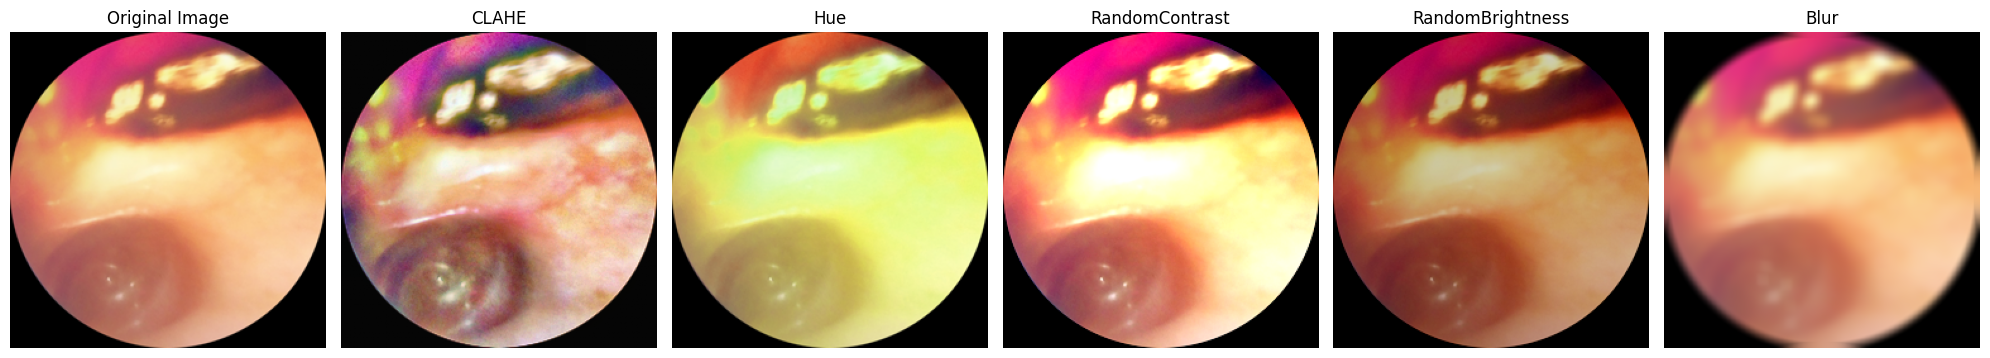

In [31]:
# 시각화를 위한 함수
def visualize_augmentations(image, augmentations):
    fig, axes = plt.subplots(1, len(augmentations) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(augmentations.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 각 증강 기법을 적용.
augmentations = {
    'CLAHE': CLAHE(image),
    'Hue': Hue(image),
    'RandomContrast': RandomContrast(image),
    #'RandomGamma': RandomGamma(image),
    'RandomBrightness': RandomBrightness(image),
    'Blur': Blur(image)
    #'gray': gray(image)
}

# 시각화 실행
visualize_augmentations(image, augmentations)

In [17]:
normal_indices = [i for i, label in enumerate(y_train) if label == 0] #정상이미지와 라벨 불러오기
abnormal_indices = [j for j, label in enumerate(y_train) if label == 1] #비정상이미지와 라벨 불러오기

selected_normal_images = [(x_train[i]) for i in normal_indices] 
selected_normal_indexs = [(y_train[i]) for i in normal_indices]
selected_abnormal_images = [(x_train[j]) for j in abnormal_indices]
selected_abnormal_indexs = [(y_train[j]) for j in abnormal_indices]

In [18]:
print("선택된 정상 고막 이미지 경로 및 라벨:")
print(selected_normal_images[:3])
print(selected_normal_indexs[:3])
print(len(selected_normal_images), len(selected_normal_indexs))

print("선택된 비정상 고막 이미지 경로 및 라벨:")
print(selected_abnormal_images[:3])
print(selected_abnormal_indexs[:3])
print(len(selected_abnormal_images), len(selected_abnormal_indexs))

선택된 정상 고막 이미지 경로 및 라벨:
['/home/jeonk636/ear_classification/eardrumDs/Normal/normal_405.tiff', '/home/jeonk636/ear_classification/eardrumDs/Normal/normal_514.tiff', '/home/jeonk636/ear_classification/eardrumDs/Normal/normal_407.tiff']
[0, 0, 0]
342 342
선택된 비정상 고막 이미지 경로 및 라벨:
['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_35.tiff', '/home/jeonk636/ear_classification/eardrumDs/Earwax/buson_124.tiff', '/home/jeonk636/ear_classification/eardrumDs/OtitExterna/otitexterna_12.tiff']
[1, 1, 1]
250 250


## 증강함수 적용

In [19]:
aug_func_spatial = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate
    #'crop': crop
}

aug_ratio_spatial = {
    'flip_H': 0.3,
    'flip_V': 0.3,
    'rotate': 0.4
    #'crop': 0.25
}

aug_func_pixel = {
    'CLAHE': CLAHE,
    'Hue': Hue,
    'RandomContrast': RandomContrast,
    #'RandomGamma': RandomGamma,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur
    #'gray': gray
}

aug_ratio_pixel = {
    'CLAHE': 0.2,
    'Hue': 0.1,
    'RandomContrast': 0.1,
    #'RandomGamma': 0.1,
    'RandomBrightness': 0.3,
    'Blur': 0.3
    #'gray': 0.1
}

def apply_aug_spatial(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys())  # 사전의 키를 리스트로 변환
    probabilities = [ratios[name] for name in func_names]  # 확률 추출
    aug_choice = np.random.choice(func_names, p=probabilities)  # 확률에 따라 선택
    augmented_image = aug_func_spatial[aug_choice](images)  # 증강 함수 적용
    augmented_images.append(augmented_image)
    return augmented_images

def apply_aug_pixel(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys()) 
    probabilities = [ratios[name] for name in func_names]
    aug_choice = np.random.choice(func_names, p=probabilities) 
    augmented_image = aug_func_pixel[aug_choice](images)
    augmented_images.append(augmented_image)
    return augmented_images


### Normal 이미지에 적용

In [20]:
random_select_normal = random.sample(selected_normal_images, 329)

aug_normal = []
for image in random_select_normal:
    tensor = load_and_preprocess_image(image)  # RGB를 array로 변환
    aug_normal.extend(apply_aug_spatial(tensor, aug_func_spatial, aug_ratio_spatial))
    aug_normal.extend(apply_aug_pixel(tensor, aug_func_pixel, aug_ratio_pixel))

aug_normal_label = [0]*658

In [21]:
print(len(aug_normal))
print(len(aug_normal_label))

658
658


### Abnormal 이미지에 적용

In [22]:
random_select_abnormal = random.choices(selected_abnormal_images, k=375)

aug_abnormal = []
for image in random_select_abnormal:
    tensor = load_and_preprocess_image(image)
    aug_abnormal.extend(apply_aug_spatial(tensor, aug_func_spatial, aug_ratio_spatial))
    aug_abnormal.extend(apply_aug_pixel(tensor, aug_func_pixel, aug_ratio_pixel))

aug_abnormal_label = [1]*750

In [23]:
print(len(aug_abnormal))
print(len(aug_abnormal_label))

750
750


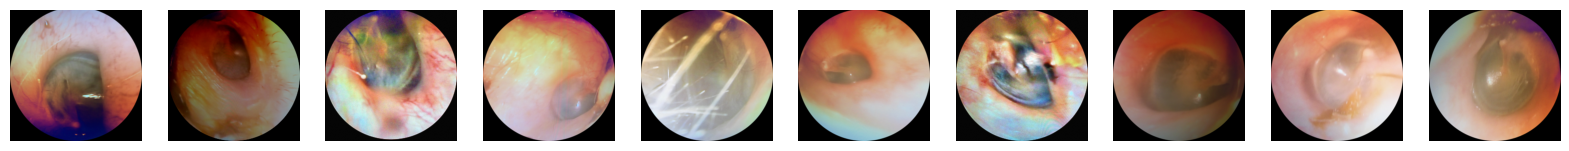

In [24]:
def plot_images(images):
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(images[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

im = random.sample(aug_normal, 10)
# 시각화 실행
plot_images(im)

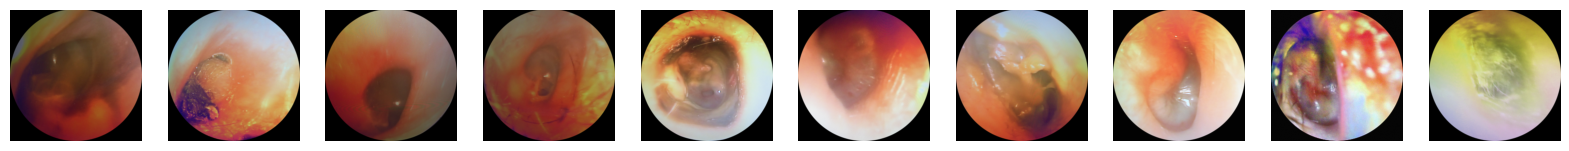

In [25]:
# 시각화 실행
im_ab = random.sample(aug_abnormal, 10)
plot_images(im_ab)

# 증강함수를 적용한 후 CNN

In [26]:
x_train = [load_and_preprocess_image(path) for path in x_train]
x_val = [load_and_preprocess_image(path) for path in x_val]
x_test = [load_and_preprocess_image(path) for path in x_test]

In [27]:
# NumPy 배열로 변환 (필요한 경우)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

aug_normal_label = np.array(aug_normal_label)
aug_abnormal_label = np.array(aug_abnormal_label)

def resize_image(image, target_size=(250, 250)):
    return tf.image.resize(image, target_size)
    
aug_normal_resized = [resize_image(img) for img in aug_normal]
aug_abnormal_resized = [resize_image(img) for img in aug_abnormal]

x_train_resized = [resize_image(img) for img in x_train]

new_y_train = np.concatenate([y_train, aug_normal_label, aug_abnormal_label])

new_x_train = x_train_resized + aug_normal_resized + aug_abnormal_resized

print(len(new_x_train)) 
print(len(new_y_train))

2000
2000


In [28]:
# for img in x_test:
#     print(img.shape, img.dtype)

In [29]:
#기존 tf CNN에만 적용하는 코드
new_x_train = tf.stack(new_x_train) 
x_val = tf.stack(x_val)
x_test = tf.stack(x_test)

In [30]:
print("new_x_train 길이:", len(new_x_train))
print("new_y_train 길이:", len(new_y_train))
print("x_val 길이:", len(x_val))
print("y_val 길이:", len(y_val))
print("x_test 길이:", len(x_test))
print("y_test 길이:", len(y_test))

new_x_train 길이: 2000
new_y_train 길이: 2000
x_val 길이: 148
y_val 길이: 148
x_test 길이: 185
y_test 길이: 185


#### 크기 250, spatial과 pixel 증강을 따로 적용, 다소 무난한 증강 적용

In [31]:
logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
strategy = tf.distribute.MirroredStrategy(logical_gpus)

# Define the model
#with tf.device("/gpu:0"):
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history = model.fit(new_x_train, new_y_train, epochs=40, validation_data=(x_val, y_val))

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/40
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:loc

2024-05-13 01:03:59.102981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 01:03:59.876016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 01:04:00.778265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 01:04:01.137090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 01:04:01.151645: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 01:04:01.155362: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-05-13 01:04:0

 1/63 [..............................] - ETA: 12:52 - loss: 0.7074 - accuracy: 0.3750

2024-05-13 01:04:05.275339: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-05-13 01:04:05.404497: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


63/63 [==============================] - 17s 71ms/step - loss: 1.1013 - accuracy: 0.5705 - val_loss: 0.6447 - val_accuracy: 0.6351
Epoch 2/40
63/63 [==============================] - 2s 36ms/step - loss: 0.6359 - accuracy: 0.6350 - val_loss: 0.6159 - val_accuracy: 0.6757
Epoch 3/40
63/63 [==============================] - 2s 36ms/step - loss: 0.5982 - accuracy: 0.6865 - val_loss: 0.5974 - val_accuracy: 0.6824
Epoch 4/40
63/63 [==============================] - 2s 37ms/step - loss: 0.5691 - accuracy: 0.7050 - val_loss: 0.6777 - val_accuracy: 0.6757
Epoch 5/40
63/63 [==============================] - 2s 36ms/step - loss: 0.5511 - accuracy: 0.7225 - val_loss: 0.7775 - val_accuracy: 0.5676
Epoch 6/40
63/63 [==============================] - 2s 36ms/step - loss: 0.5507 - accuracy: 0.7265 - val_loss: 0.5845 - val_accuracy: 0.7230
Epoch 7/40
63/63 [==============================] - 2s 36ms/step - loss: 0.5038 - accuracy: 0.7530 - val_loss: 0.5867 - val_accuracy: 0.7162
Epoch 8/40
63/63 [=====

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 64)                1

5/5 - 0s - loss: 1.9402 - accuracy: 0.6757 - 231ms/epoch - 46ms/step


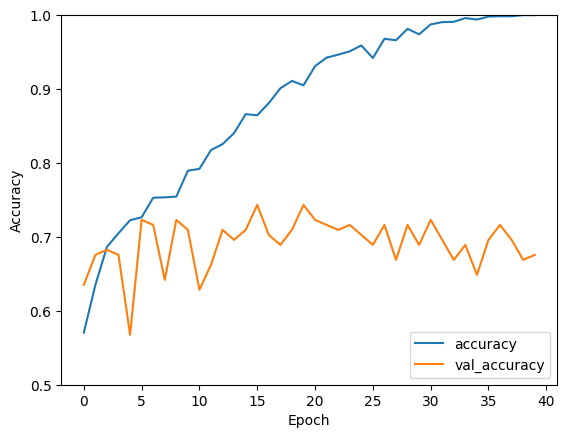

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)